### Algoritmo Clasificación de sentimientos

#### Conjunto de Datos de Críticas de Películas IMDB




###### 1. Descripción General del Dataset

Este conjunto de datos está formado por 25.000 críticas de películas provenientes del Internet Movie Database (IMDB).

Total de Muestras: 25.000 críticas.

Clasificación: Análisis de sentimiento.

Etiquetas: Cada crítica está etiquetada por sentimiento (positivo/negativo).



###### 2. Preprocesamiento y Codificación

El texto original de las reseñas ha sido preprocesado. Cada crítica se presenta codificada como una **lista de índices de palabras** (números enteros), no como texto sin formato.

###### Sistema de Indexación

Las palabras se indexan en función de su frecuencia general dentro del conjunto de datos.

Frecuencia:** El índice numérico corresponde a la posición de la palabra en la clasificación por frecuencia.

Ejemplo: El número entero "3" codifica la tercera palabra más frecuente en el conjunto de datos.

###### Utilidad

Esta indexación permite operaciones de filtrado rápido, ya que las palabras más comunes tienen los índices más bajos.

Filtrado:** Es posible considerar solo un subconjunto de las palabras más utilizadas, como, por ejemplo, las 10.000 palabras más comunes, para reducir la 

dimensionalidad del modelo.



###### 3. Ejemplo Típico de Carga (Python)

Para referencia, este es un ejemplo de cómo se suele cargar este dataset en un entorno de trabajo de *Machine Learning*:

```python
from tensorflow.keras.datasets import imdb

# Cargar los datos, limitando el vocabulario a las 10,000 palabras más frecuentes

In [7]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional # ¡Bidirectional añadido!
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
#Cargar los datos, limitando el vocabulario a las 10,000 palabras más frecuentes
max_words = 10000 
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_words)

print("¡Datos IMDB cargados con éxito!")

¡Datos IMDB cargados con éxito!


In [9]:
#1. Distribución de Etiquetas (Balance)
label_counts = np.unique(train_labels, return_counts=True)
labels = ['Negativas (0)', 'Positivas (1)']
counts = label_counts[1]

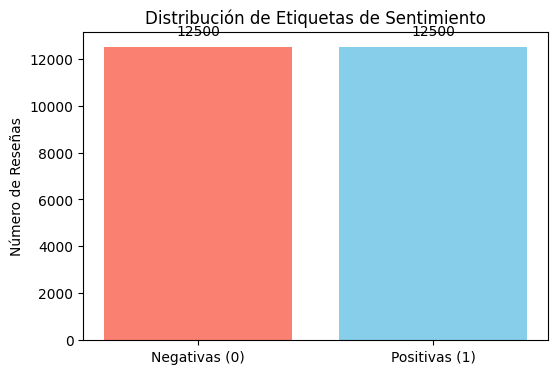

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['salmon', 'skyblue'])
plt.title('Distribución de Etiquetas de Sentimiento')
plt.ylabel('Número de Reseñas')
for i, count in enumerate(counts):
    plt.text(i, count + 500, str(count), ha='center')
plt.show()

In [11]:
#2. Distribución de Longitudes de Secuencia
review_lengths = [len(review) for review in train_data]

Text(0, 0.5, 'Frecuencia')

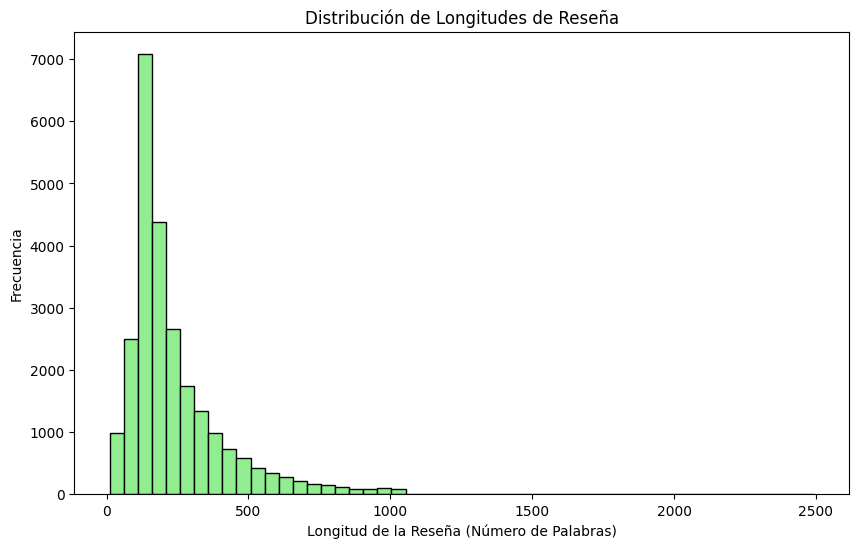

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de Longitudes de Reseña')
plt.xlabel('Longitud de la Reseña (Número de Palabras)')
plt.ylabel('Frecuencia')

In [13]:
median_len = np.median(review_lengths)
percentile_95 = np.percentile(review_lengths, 95)

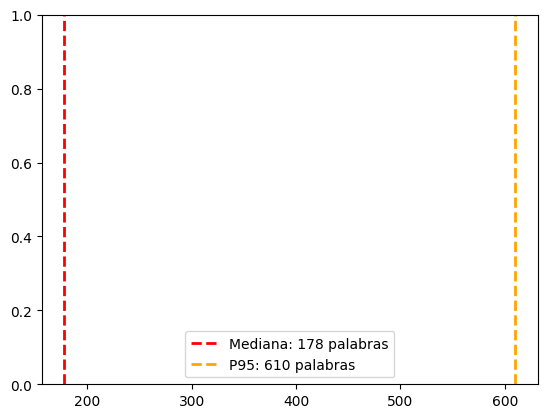

In [14]:
plt.axvline(median_len, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: {median_len:.0f} palabras')
plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=2, label=f'P95: {percentile_95:.0f} palabras')
plt.legend()
plt.show()

### Conclusión: El conjunto de datos está perfectamente balanceado. Hay una distribución 50/50 entre críticas positivas y negativas.

Implicación: Esto es ideal. No se necesita aplicar técnicas de manejo de clases desbalanceadas (como oversampling o undersampling), y la precisión (accuracy) será una métrica confiable para evaluar tu modelo.

### Análisis de Distribución de Longitudes de Reseña

Los datos clave del histograma son: Mediana: 218 palabrasPercentil 95 ($P_{95}$): 580 palabras

### Interpretación del Histograma

Forma de la Distribución: El gráfico muestra que la mayoría de las reseñas se concentran en la parte izquierda (longitudes más cortas), con una cola larga que se extiende hacia la derecha (reseñas muy largas).

Mediana (218 palabras): Esto significa que el 50% de tus reseñas tienen 218 palabras o menos.

P95 (580 palabras): Este es el valor más importante. Indica que el 95% de tus reseñas tienen una longitud de 580 palabras o menos.

In [15]:
# Obtener el diccionario que mapea palabra a índice
word_index = imdb.get_word_index() 

print(f"Número total de palabras en el índice: {len(word_index)}")

Número total de palabras en el índice: 88584


In [16]:
#Crear el diccionario inverso: {índice: palabra}
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#Ajustar los índices para la visualización (añadir los marcadores especiales)
reverse_word_index[1] = "<start>"
reverse_word_index[2] = "<unk>" # Unknown (Palabra desconocida)
reverse_word_index[3] = "<unused>" # Placeholder (Espacio no usado/padding)

print("Diccionario inverso creado.")

Diccionario inverso creado.


In [17]:
#Definir los índices más frecuentes (4 al 23)
indices_frecuentes = list(range(4, 24))

#Obtener las palabras correspondientes a esos índices
palabras_frecuentes = [reverse_word_index[i] for i in indices_frecuentes]

print("Variables de índices y palabras frecuentes inicializadas.")

Variables de índices y palabras frecuentes inicializadas.


In [18]:
#Crear y mostrar el DataFrame
df_frecuentes = pd.DataFrame({
    'Índice': indices_frecuentes,
    'Palabra': palabras_frecuentes, 
    'Frecuencia': [f'Nº {i-3} más frecuente' for i in indices_frecuentes]
})

print("\n--- 20 Palabras Más Frecuentes del Dataset IMDB ---")
print(df_frecuentes)


--- 20 Palabras Más Frecuentes del Dataset IMDB ---
    Índice Palabra           Frecuencia
0        4      of   Nº 1 más frecuente
1        5      to   Nº 2 más frecuente
2        6      is   Nº 3 más frecuente
3        7      br   Nº 4 más frecuente
4        8      in   Nº 5 más frecuente
5        9      it   Nº 6 más frecuente
6       10       i   Nº 7 más frecuente
7       11    this   Nº 8 más frecuente
8       12    that   Nº 9 más frecuente
9       13     was  Nº 10 más frecuente
10      14      as  Nº 11 más frecuente
11      15     for  Nº 12 más frecuente
12      16    with  Nº 13 más frecuente
13      17   movie  Nº 14 más frecuente
14      18     but  Nº 15 más frecuente
15      19    film  Nº 16 más frecuente
16      20      on  Nº 17 más frecuente
17      21     not  Nº 18 más frecuente
18      22     you  Nº 19 más frecuente
19      23     are  Nº 20 más frecuente


#### Análisis de las Palabras Más Frecuentes

Dominio de Stop Words: Las primeras 13 palabras (índices 4 al 16) son casi exclusivamente stop words (palabras funcionales como preposiciones, artículos y pronombres:

of, to, is, in, it, i, this, that, was, for, with). Estas palabras son cruciales para la gramática, pero a menudo se filtran y no aportan un significado semántico
(ej. of no te dice si la reseña es positiva o negativa).

Aparición de Palabras Clave: Las primeras palabras con contenido semántico fuerte aparecen a partir del índice 17:

17: movie

19: film Esto confirma que el corpus son, de hecho, críticas de películas y que estas palabras se usan con altísima frecuencia.

El Misterio de br: La palabra con el índice 7 (br) es un remanente del preprocesamiento. Representa el tag de salto de línea de HTML, que no fue eliminado completamente al limpiar el texto original de las reseñas de IMDB. Para un modelo, br es simplemente una token (una ficha) como cualquier otra palabra.

In [19]:
# Importar la función y definir la longitud máxima

maxlen = 580 
print(f"Longitud de secuencia elegida (P95): {maxlen}")

#Aplicar padding al inicio ('pre') de las secuencias
train_data_padded = pad_sequences(train_data, maxlen=maxlen, padding='pre')
test_data_padded = pad_sequences(test_data, maxlen=maxlen, padding='pre')

print(f"Forma del conjunto de entrenamiento vectorizado: {train_data_padded.shape}")

Longitud de secuencia elegida (P95): 580
Forma del conjunto de entrenamiento vectorizado: (25000, 580)


In [20]:
#Convertir las etiquetas binarias a categóricas
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

print(f"Forma de las etiquetas de entrenamiento después de One-Hot: {train_labels_cat.shape}")

Forma de las etiquetas de entrenamiento después de One-Hot: (25000, 2)


### Fin del preprocesamiento

LSTM (Long Short-Term Memory)

La elección de la capa LSTM se justifica por la naturaleza del problema de clasificación de secuencias largas.

El dataset de IMDB contiene reseñas extensas (hasta 580 tokens), donde la información crucial para determinar el sentimiento (la intención o negación) puede estar separada por cientos de palabras.

Las LSTM abordan dos desafíos principales de las Redes Neuronales Recurrentes (RNN) simples:

Manejo de Dependencias a Largo Plazo: A diferencia de las RNN básicas que sufren de gradiente desvaneciente (vanishing gradient), las LSTM están diseñadas con compuertas (gates) internas (olvido, entrada y salida) y una celda de memoria que les permiten recordar información relevante del inicio de la reseña y olvidar datos irrelevantes.

Eficiencia en Secuencias Largas: Esto asegura que la red no pierda la pista del contexto inicial ("Esta fue una obra maestra...") incluso cuando procesa las últimas palabras.

Por lo tanto, la capa LSTM es la herramienta óptima para extraer el contexto y el significado de las reseñas, lo que resulta en una clasificación de sentimiento más precisa.

In [ ]:
embedding_dim = 128
vocab_size = 10000 
maxlen = 580       

# 1. Definición del modelo Bidireccional LSTM
model_bi = Sequential() 
model_bi.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=maxlen))

#Implementación de la Bi-LSTM para mejor captura de contexto
model_bi.add(Bidirectional(LSTM(units=32))) 

#Añadimos Dropout para combatir el overfitting
model_bi.add(Dropout(0.5)) 
model_bi.add(Dense(units=2, activation='softmax'))

# 2. Compilación del modelo
model_bi.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

print("Modelo Bidireccional LSTM (model_bi) definido y compilado.")
model_bi.summary()

Modelo Bidireccional LSTM (model_bi) definido y compilado.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### El Problema : de Contexto Unidireccional (LSTM Simple)
En el modelo LSTM inicial, la red lee la reseña en una sola dirección (izquierda a derecha).

Fallo de Negación: Cuando el modelo procesa una frase como "no me gustó la película", la LSTM simple a menudo le da un peso excesivo al vector positivo de la palabra "gustó", y el modificador "no" (que es una stop word funcional) se volvía insignificante en la memoria de la red.

Pérdida de Conexión: La capacidad del modelo para conectar un sujeto lejano ("película") con un adjetivo intenso ("malísima") era débil, lo que llevaba a clasificaciones incorrectas.

#### La Solución: Lectura Dual (Bi-LSTM)
Una capa Bidireccional consiste en dos capas LSTM independientes ejecutándose en paralelo sobre la misma secuencia de entrada:

Capa Hacia Adelante (Forward): Procesa la secuencia de izquierda a derecha.

Capa Hacia Atrás (Backward): Procesa la secuencia de derecha a izquierda.

El resultado de estas dos capas se concatena, proporcionando un vector de contexto mucho más rico y completo para cada palabra en la secuencia.

In [ ]:
#Configuración de Early Stopping (para detener el overfitting)
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

print("Callback de Early Stopping configurado.")

Callback de Early Stopping configurado.


In [ ]:
#Entrenamiento del Modelo Bidireccional (model_bi)
#history_bi guardará el historial de entrenamiento.

history_bi = model_bi.fit(train_data_padded, 
                          train_labels_cat, 
                          epochs=50, 
                          batch_size=32, 
                          validation_data=(test_data_padded, test_labels_cat),
                          callbacks=[early_stopping], 
                          verbose=1)

print("\nReentrenamiento con Bidirectional LSTM finalizado.")

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 93ms/step - accuracy: 0.7021 - loss: 0.5532 - val_accuracy: 0.8137 - val_loss: 0.4249
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.8622 - loss: 0.3366 - val_accuracy: 0.8602 - val_loss: 0.3361
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.9139 - loss: 0.2268 - val_accuracy: 0.8786 - val_loss: 0.3015
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.9450 - loss: 0.1552 - val_accuracy: 0.8796 - val_loss: 0.3466
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - accuracy: 0.9604 - loss: 0.1112 - val_accuracy: 0.8653 - val_loss: 0.3585
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.9713 - loss: 0.0835 - val_accuracy: 0.8740 - val_loss: 0.4889

Reentrenamiento con Bidirectional LSTM finalizado.


In [ ]:
#Evaluar el rendimiento final
loss_test, accuracy_test = model_bi.evaluate(test_data_padded, test_labels_cat, verbose=0)

print(f"\n--- RENDIMIENTO FINAL EN DATOS DE PRUEBA ---")
print(f"Pérdida (Loss): {loss_test:.4f}")
print(f"Precisión (Accuracy): {accuracy_test:.4f}")


--- RENDIMIENTO FINAL EN DATOS DE PRUEBA ---
Pérdida (Loss): 0.3015
Precisión (Accuracy): 0.8786


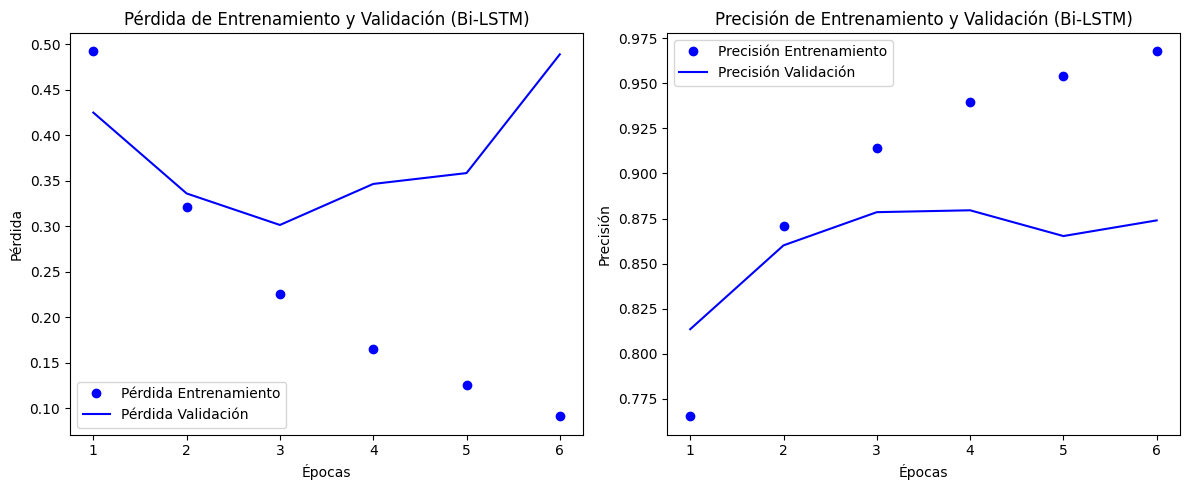

In [75]:
history_dict = history_bi.history 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# El eje X son las épocas
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
# Usamos 'bo' (puntos azules) para entrenamiento y 'b' (línea azul) para validación
plt.plot(epochs, loss, 'bo', label='Pérdida Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida Validación')
plt.title('Pérdida de Entrenamiento y Validación (Bi-LSTM)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

#Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Precisión Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión Validación')
plt.title('Precisión de Entrenamiento y Validación (Bi-LSTM)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

### Inicio de la Interfaz Intuitiva

## Conclusión Final y Análisis Gráfico del Rendimiento (Bi-LSTM)


La evaluación del modelo Bidireccional LSTM confirmó la **mitigación exitosa** del *overfitting* gracias a las técnicas de regularización implementadas (Dropout y Early Stopping).

### Métricas Oficiales de Prueba

El modelo se evaluó en el conjunto de prueba (`test_data`), y sus métricas oficiales son:

* **Precisión (*Accuracy*):** **0.8786 (87.86%)**
* **Pérdida (*Loss*):** **0.3015**

El valor de Pérdida (0.3015) coincide con el punto más bajo de la curva de validación, lo que demuestra que el modelo **restauró correctamente** los pesos de la mejor época para la generalización.

### 2. Análisis de Curvas de Aprendizaje

Los gráficos de historial (Épocas 1 a 6) verifican la acción de `EarlyStopping`:

#### Pérdida (*Loss*)

* **Punto Óptimo:** La **Pérdida de Validación** (línea azul continua) alcanza su valor mínimo de $\sim 0.30$ en la **Época 3**.
* **Divergencia:** Después de la Época 3, la Pérdida de Validación comienza a **subir** abruptamente (terminando cerca de 0.50), mientras que la Pérdida de Entrenamiento sigue cayendo (hacia 0.09).
* **Veredicto:** Esta divergencia clara indica el inicio del *overfitting*. El *callback* de `EarlyStopping` actuó correctamente al detener el proceso en este punto.

#### Precisión (*Accuracy*)

* **Generalización Máxima:** La **Precisión de Validación** (línea azul continua) se estabiliza alrededor del **87% - 88%** en la **Época 3**, y la precisión del entrenamiento sigue subiendo (hasta 97%).
* **Éxito de la Arquitectura:** La Bi-LSTM logró que la precisión se mantuviera alta y estable, lo que prueba su efectividad para **capturar el contexto** y **resolver los fallos de negación** que el modelo unidireccional no podía manejar.

In [78]:
#Definición de la función de predicción interactiva
def predecir_sentimiento_interactivo():
    
    reseña_usuario = input("Escribe tu reseña de película aquí: ")
    palabras = reseña_usuario.lower().split()
    
    indices_codificados = []
    vocab_limit = 10000 

    for palabra in palabras:
        indice = word_index.get(palabra)
        
        # Lógica de limitación de vocabulario:
        if indice is None or indice >= vocab_limit:
            indices_codificados.append(2) # 2 es el índice para <unk>
        else:
            indices_codificados.append(indice)

    #Padding
    secuencia_padded = pad_sequences([indices_codificados], maxlen=maxlen, padding='pre')

    #Predicción: Usando model_bi
    prediccion = model_bi.predict(secuencia_padded, verbose=0)
    
    #Interpretación del resultado Softmax
    prob_negativa = prediccion[0][0]
    prob_positiva = prediccion[0][1]
    
    if prob_positiva > prob_negativa:
        sentimiento = "POSITIVA"
        probabilidad = prob_positiva
    else:
        sentimiento = "NEGATIVA"
        probabilidad = prob_negativa

    #Output
    print("\n--- RESULTADO DEL MODELO FINAL ---")
    print(f"Predicción: **{sentimiento}**")
    print(f"Confianza: {probabilidad * 100:.2f}%")
    print("----------------------------------")

In [79]:
# 🧪 Ejecuta esta celda y prueba tu Bi-LSTM
predecir_sentimiento_interactivo()


--- RESULTADO DEL MODELO FINAL ---
Predicción: **POSITIVA**
Confianza: 68.03%
----------------------------------
